In [16]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b

In [17]:
start_date = datetime(2019,1,1)
end_date = datetime(2023,1,1)

In [18]:
market = Market()
speculation_db = ADatabase("btc_class_spec")

In [19]:
speculation_db.connect()
t = speculation_db.retrieve("trades")
speculation_db.disconnect()
t["delta"] = (t["sell_price"] - t["adjclose"]) / t["adjclose"]
t["holding"] = [(row[1]["sell_date"] - row[1]["date"]).days for row in t.iterrows()]

In [20]:
reqs = [0.05,0.1,0.15]
signals = [0.05,0.1,0.15]
values = [True,False]
parameters = []
positions = 1
for value in values:
    for signal in signals:
        for req in reqs:
            parameter = {"value":value,"signal":signal,"req":req}
            parameters.append(parameter)

In [21]:
analysis = []
for parameter in parameters:
    for position in range(positions):
        position_trades = t[(t["position"]==position)].sort_values("date")
        for key in parameter.keys():
            position_trades = position_trades[position_trades[key]==parameter[key]]
        initial = 100 / positions
        for delta in position_trades["delta"]:
            initial = initial * (1+delta)
        if position_trades.index.size > 0:
            wr = position_trades[position_trades["delta"]>0].index.size / position_trades.index.size
            analysis.append({
                "value":parameter["value"],
                "position":position,
                "req":parameter["req"],
                "signal":parameter["signal"],
                "holding":position_trades["holding"].mean(),
                "wr":wr,
                "pv":initial
            })
a = pd.DataFrame(analysis)

In [22]:
a

,value,position,req,signal,holding,wr,pv
0,True,0,0.05,0.05,3.500000,0.500000,73.624007
1,True,0,0.10,0.05,3.600000,0.500000,80.802765
2,True,0,0.15,0.05,3.900000,0.500000,82.783648
3,True,0,0.05,0.10,3.750000,0.500000,75.537389
4,True,0,0.10,0.10,3.875000,0.500000,79.134407
5,True,0,0.15,0.10,4.000000,0.500000,80.167496
6,True,0,0.05,0.15,3.750000,0.500000,75.537389
7,True,0,0.10,0.15,3.875000,0.500000,79.134407
8,True,0,0.15,0.15,4.000000,0.500000,80.167496
9,False,0,0.05,0.05,3.371429,0.514286,75.862648


In [23]:
complete = a.pivot_table(index=["req","value","signal"],columns="position",values="pv").reset_index()
complete["pv"] = [sum([row[1][i] for i in range(positions)]) for row in complete.iterrows()]
complete.sort_values("pv",ascending=False)

position,req,value,signal,0,pv
9,0.15,False,0.05,134.980141,134.980141
5,0.10,False,0.05,113.443305,113.443305
1,0.05,False,0.10,98.770411,98.770411
10,0.15,True,0.05,82.783648,82.783648
6,0.10,True,0.05,80.802765,80.802765
11,0.15,True,0.10,80.167496,80.167496
12,0.15,True,0.15,80.167496,80.167496
7,0.10,True,0.10,79.134407,79.134407
8,0.10,True,0.15,79.134407,79.134407
0,0.05,False,0.05,75.862648,75.862648


In [24]:
top = complete.sort_values("pv",ascending=False).iloc[0]
analysis = t[(t["req"]==top["req"]) & (t["value"]==top["value"]) & (t["signal"]==top["signal"])]
ledger = analysis[["date","sell_date","ticker","delta","projected_delta","position"]]
ledger["delta"] = ledger["delta"] + 1

In [25]:
ledger

,date,sell_date,ticker,delta,projected_delta,position
148,2020-01-07,2020-01-10,BTC,1.000351,0.077403,0
149,2020-01-14,2020-01-17,BTC,1.011472,0.063668,0
150,2020-01-28,2020-01-31,BTC,0.999139,0.081394,0
151,2020-02-10,2020-02-14,BTC,1.046213,0.072156,0
152,2020-03-24,2020-03-27,BTC,0.960651,0.053313,0
153,2020-04-06,2020-04-10,BTC,0.944128,0.085016,0
154,2020-04-27,2020-05-01,BTC,1.137150,0.085402,0
155,2020-05-04,2020-05-08,BTC,1.104347,0.104016,0
156,2020-05-18,2020-05-22,BTC,0.944071,0.108276,0
157,2020-06-01,2020-06-05,BTC,0.950652,0.057027,0


In [26]:
metric = "position"

In [27]:
portfolio = ledger.pivot_table(index="sell_date",columns=metric,values="delta").fillna(1).reset_index()
portfolio.reset_index()

position,index,sell_date,0
0,0,2020-01-10,1.000351
1,1,2020-01-17,1.011472
2,2,2020-01-31,0.999139
3,3,2020-02-14,1.046213
4,4,2020-03-27,0.960651
5,5,2020-04-10,0.944128
6,6,2020-05-01,1.137150
7,7,2020-05-08,1.104347
8,8,2020-05-22,0.944071
9,9,2020-06-05,0.950652


In [28]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date"] = portfolio["sell_date"]
cumulative["pv"] = [sum([row[1][column] * 1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/prices/BTC-USD.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,date,pv,adjclose,bench
0,1.000351,2020-01-10,1.000351,8166.554199,1.000000
1,1.011827,2020-01-17,1.011827,8929.038086,1.093367
2,1.010955,2020-01-31,1.010955,9350.529297,1.144979
3,1.057675,2020-02-14,1.057675,10312.116211,1.262725
4,1.016057,2020-03-27,1.016057,6469.798340,0.792231
5,0.959288,2020-04-10,0.959288,6865.493164,0.840684
6,1.090854,2020-05-01,1.090854,8864.766602,1.085497
7,1.204681,2020-05-08,1.204681,9842.666016,1.205241
8,1.137305,2020-05-22,1.137305,9182.577148,1.124413
9,1.081181,2020-06-05,1.081181,9665.533203,1.183551


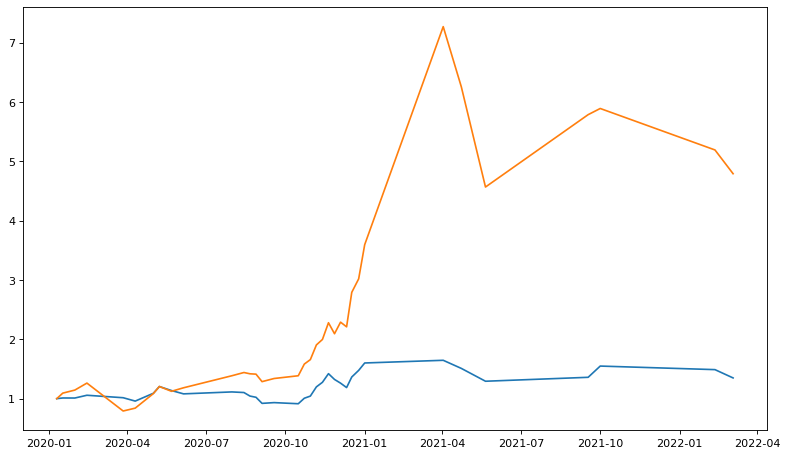

In [29]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])

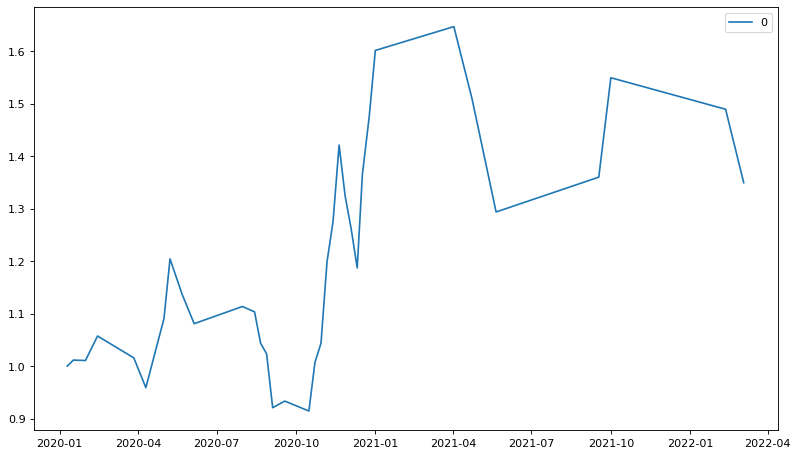

In [30]:
plt.figure(figsize=(12, 7), dpi=80)
for i in counted_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
    plt.legend(counted_columns)
plt.show()
